In [53]:
# %load https://raw.githubusercontent.com/hassothea/AggregationMethods/main/GradientCOBRARegressor.py

# Import all the libraries 
# ========================

# Import all the libraries 
# ========================
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV, LassoCV, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.utils.validation import check_X_y, check_array
from scipy import spatial, optimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Plotting figures
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import gaussian_kde as kde
# Table type
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
import warnings

class GradientCOBRA(BaseEstimator):
    def __init__(self, 
                random_state = None, 
                learning_rate = 0.1,
                speed = 'constant',
                estimator_list = None, 
                estimator_params = None, 
                opt_method = "grad",
                opt_params = None,
                kernel = 'radial', 
                kernel_params = None,
                show_progress = True,
                loss_function = None,
                loss_weight = None,
                beta = 0.1):
        """
        This is a class of the implementation of the Kernel-based consensual aggregation method for regression by Has (2023).


        * Parameters:
        ------------
            - `random_state`: (default is `None`) set the random state of the random generators in the class.
            
            - `estimator_list`: (default is None) the list of intial estimators (machines as addressed in Biau et al. (2016)). 
                If it is None, intial estimators: 'knn', 'ridge', 'lasso', 'tree', 'random_forest' and 'svm' are used with default parameters.
                It should be a sublist of the following list: ['knn', 'ridge', 'lasso', 'tree', 'random_forest', 'svm', 'sgd', 'bayesian_ridge', 'adaboost', 'gradient_boost'].
            
            - `estimator_params`: (default is `None`) a dictionary containing the parameters of the basic estimators given in the `estimator_list` argument. 
                It must be a dictionary with:
                - `key`     : the name of the basic estimator defined in `estimator_list`, 
                - `value`   : a dictionary with (key, value) = (parameter, value).

            - `learning_rate`: (default is `0.1`) the learning rate in gradient descent algorithm for estimating the optimal bandwidth.

            - `speed`: (default is `constant`) the adjusting speed of the learning rate. It is helpful when the cost function is flate around the optimal value, changing the learning speed might help the algorithm to converge faster.
                It should be an element of ['constant', 'linear', 'log', 'sqrt_root', 'quad', 'exp'].

            - `opt_method`: (default is "grad") optimization algorithm for estimating the bandwidth parameter. 
                It should be either "grid" (grid search) or "grad" (gradient descent for non-compactly supported kernel). 
                By default, it is set to be "grad" with default "radial" kernel.
            
            - opt_params: (default is 'None') a dictionary of additional parameters for the optimization algorithm (both grid search and gradient descent). 
                Its should contain some of the following keys:
                - 'bandwidth_grid'  : a list of bandwidth parameters for grid search algorithm (default = np.linspace(0.00001, 10, 300))
                - 'epsilon'         : stopping criterion for gradient descent algorithm (default = 10 ** (-5))
                - 'n_tries'         : the number of tries for selecting initial position of gradient descent algorithm (default = 5)
                - 'start'           : the initial value of the bandwidth parameter (default = None)
                - 'max_iter'        : maximum iteration of gradient descent algorithm (default = 300)
                - 'n_cv'            : number of cross-validation folds (default = int(5))
                - 'precision'       : the precision to estimate the gradient for gradient descent algorithm (default = 2 * 10 ** (-5)).
            
             - `kernel`: (default is 'radial') the kernel function used for the aggregation. 
                It should be an element of the list ['exponential', 'gaussian', 'radial', 'cauchy', 'reverse_cosh', 'epanechnikov', 'biweight', 'triweight', 'triangular', 'cobra', 'naive'].
                Some options such as 'gaussian' and 'radial' lead to the same radial kernel function. 
                For 'cobra' or 'naive', they correspond to Biau et al. (2016).

            - `kernel_params`: (default is None) a dictionary of the following keys:
                - 'alpha'       : exponential of the exponential and radial kernel function i.e., K(x) = exp(|x|^{\alpha}}). By default, alpha = 2.0,
                - 'sigma'       : the standard deviation used to normalize the scale in all kernel function function i.e. K(x) = K(x/sigma). By default, sigma = 1.0.

            - show_progress: (default is `True`) boolean defining whether or not to show the progress of the optimization algorithm for both grid search and gradient descent.

            - `loss_function`: (default is None) a function or string defining the cost function to be optimized for estimating the optimal bandwidth parameter.
                By defalut, the K-Fold cross-validation MSE is used. Otherwise, it must be either:
                - a function of two argumetns (y_true, y_pred) or
                - a string element of the list ['mse', 'mae', 'mape', 'weighted_mse']. If it is `weighted_mse`, one can define the weight for each training point using `loss_weight` argument below.
            
            - `loss_weight`: (default is None) a list of size equals to the size of the training data defining the weight for each individual data point in the loss function. 
                If it is None and the `loss_function = weighted_mse`, then a normalized weight W(i) = 1/PDF(i) is assigned to individual i of the training data.
            
            - `beta`: (default is 0.1) a constant beta in exponential function for `loss_weight` defined by $W(i)=\exp(\beta/PDF(i))$.

        * Returns:
        ---------
            self : returns an instance of self. 

        * Methods: 
        ---------
            - fit : fitting the aggregation method on the design features (original data or predicted features).
            - split_data : split the data into D_k = {(X_k,y_k)} and D_l = {(X_l,y_l)} to construct the estimators and perform aggregation respectively.
            - build_basic_estimators : build basic estimators for the aggregation. It is also possible to set the values of (hyper) parameters for each estimators.
            - load_predictions : to make predictions using constructed basic estimators.
            - distances : construct distance matrix according to the kernel function used in the aggregation.
            - kappa_cross_validation_error : the objective function to be minimized.
            - optimize_bandwidth : the optimization method to estimate the optimal bendwidth parameter.
            - predict : for building prediction on the new observations using any given bendwidth or the estimated one.
            - plot_learning_curve : for plotting the graphic of learning algorithm (error vs parameter).
        """

        self.random_state = random_state
        self.learning_rate = learning_rate
        self.speed = speed
        self.kernel = kernel
        self.estimator_list = estimator_list
        self.show_progress = show_progress
        self.estimator_params = estimator_params
        self.opt_method = opt_method
        self.opt_params = opt_params
        self.kernel_params = kernel_params
        self.loss_weight = loss_weight
        self.loss_function = loss_function
        self.beta = beta

    # List of kernel functions
    def reverse_cosh(self, x, y):
        return 1/np.cosh(-x*(y/self.kernel_params_['sigma']))
        
    def exponential(self, x, y):
        return np.exp(-y*(x/self.kernel_params_['sigma']) ** self.kernel_params_['alpha'])

    def radial(self, x, y):
        return np.exp(-x*y/self.kernel_params_['sigma'])
        
    def epanechnikov(self, x, y):
        return (1 - x*y/self.kernel_params_['sigma']) * (x*y/self.kernel_params_['sigma'] < 1)
        
    def biweight(self, x, y):
        return (1-x*y/self.kernel_params_['sigma']) ** 2 * (x*y/self.kernel_params_['sigma'] < 1)
        
    def triweight(self, x, y):
        return (1-x*y/self.kernel_params_['sigma']) ** 3 * (x*y/self.kernel_params_['sigma'] < 1)
        
    def triangular(self, x, y):
        return (1-np.abs(x*y/self.kernel_params_['sigma'])) * (x*y/self.kernel_params_['sigma'] < 1)
        
    def naive(self, x, y):
        return np.array(x*y/self.kernel_params_['sigma'])
        
    def cauchy(self, x, y):
        return 1/(1 + np.array(x*y/self.kernel_params_['sigma']))
    
    # List of loss functions
    def mse(self, y_true, pred, id = None):
        return mean_squared_error(y_true, pred)
    def mae(self, y_true, pred, id = None):
        return mean_absolute_error(y_true, pred)
    def mape(self, y_true, pred, id = None):
        return mean_absolute_percentage_error(y_true, pred)
    def wgt_mse(self, y_true, pred, id = None):
        w_err2 = np.dot(self.loss_weight_[id], (y_true - pred) ** 2)/(np.dot(self.loss_weight_[id], y_true) ** 2)
        return w_err2
    def loss_func(self, y_true, pred, id = None):
        return self.loss_function(y_true, pred)

    def fit(self, X, y, split = .5, overlap = 0, X_k = None, y_k = None, X_l = None, y_l = None, as_predictions = False):
        X, y = check_X_y(X, y)
        if X.dtype == object:
            X = X.astype(np.float64)
        if y.dtype == object:
            y = y.astype(np.float64)
        self.X_ = X
        self.y_ = y
        self.normalize_constant = 10 / np.abs(np.max(y))
        self.X_k_, self.X_l_ = X_k, X_l
        self.y_k_, self.y_l_ = y_k, y_l
        self.as_predictions = as_predictions
        self.basic_estimtors = {}

        opt_param = {'bandwidth_grid' : np.linspace(0.00001, 10, 300),
                     'epsilon' : 10 ** (-5),
                     'n_tries' : int(5),
                     'start' : None,
                     'max_iter' : 300,
                     'n_cv' : int(5),
                     'precision' : 2 * 10 ** (-5)
        }
        
        kernel_param = {
            'alpha' : 2.0,
            'sigma' : 1.0
        }
        
        # Set optional parameters
        if self.opt_params is not None:
            for obj in self.opt_params:
                opt_param[obj] = self.opt_params[obj]
        self.opt_params_ = opt_param
        if self.kernel_params is not None:
            for obj in self.kernel_params:
                kernel_param[obj] = self.kernel_params[obj]
        self.kernel_params_ = kernel_param

        self.opt_method_ = self.opt_method
        if self.kernel not in ['radial', 'gaussian', 'exponential', 'reverse_cosh']:
            self.opt_method_ = 'grid'

        self.list_kernels = {
            'reverse_cosh' : self.reverse_cosh,
            'exponential' : self.exponential,
            'gaussian' : self.radial,
            'radial' : self.radial,
            'epanechnikov' : self.epanechnikov,
            'biweight' : self.biweight,
            'triweight' : self.triweight,
            'triangular' : self.triangular,
            'cobra' : self.naive,
            'naive' : self.naive,
            'cauchy' : self.cauchy
        }

        # Loss function
        if (self.loss_function is None) or (self.loss_function == 'mse') or (self.loss_function == 'mean_squared_error'):
            self.loss = self.mse
        elif (self.loss_function == 'mae') or (self.loss_function == 'mean_absolute_error'):
            self.loss = self.mae
        elif (self.loss_function == "mape") or (self.loss_function == 'mean_absolute_percentage_error'):
            self.loss = self.mape
        elif (self.loss_function == 'weighted_mse') or (self.loss_function == 'weighted_mean_squared_error'):
            if self.loss_weight is None:
                pdf = kde(self.y_)(self.y_)
                wgt = 1/pdf
                wgt /= np.sum(wgt)
                self.loss_weight_ = wgt
            else:
                self.loss_weight_ = self.loss_weight
            self.loss = self.wgt_mse

        if callable(self.loss_function):
            self.loss = self.loss_func
            
        if not as_predictions:
            self.split_data(split = split, overlap=overlap)
            self.build_baisc_estimators()
            self.load_predictions()
            self.optimize_bandwidth(params = self.opt_params_)
        else:
            if X_l is not None:
                self.X_l_ = X_l
            else:
                self.X_l_ = X
            if y_l is not None:
                self.y_l_ = y_l
            else:
                self.y_l_ = y
            self.pred_X_l = self.X_l_ * self.normalize_constant
            self.number_estimators = X.shape[1]
            self.iloc_l = np.array(range(len(y)))
            self.optimize_bandwidth(params = self.opt_params_)
        return self
    
    def split_data(self, split, overlap = 0, k = None, shuffle_data = True):
        if shuffle_data:
            self.shuffled_index = shuffle(range(len(self.y_)), random_state=self.random_state)
        if k is None:
            k1 = int(len(self.y_) * (split-overlap/2))
            k2 = int(len(self.y_) * (split+overlap/2))
        self.iloc_k = np.array(self.shuffled_index[:k2], dtype = np.int64)
        self.iloc_l = np.array(self.shuffled_index[k1:], dtype = np.int64)
        self.X_k_, self.X_l_ = self.X_[self.iloc_k,:], self.X_[self.iloc_l,:]
        self.y_k_, self.y_l_ = self.y_[self.iloc_k], self.y_[self.iloc_l]
        return self

    def build_baisc_estimators(self):
        all_estimators = {
            'linear_regression' : LinearRegression(),
            'extra_trees' : ExtraTreesRegressor(random_state=self.random_state),
            'knn' : KNeighborsRegressor(),
            'lasso' : LassoCV(random_state=self.random_state),
            'ridge' : RidgeCV(),
            'tree' : DecisionTreeRegressor(random_state=self.random_state),
            'random_forest' : RandomForestRegressor(random_state=self.random_state),
            'svm' : SVR(),
            'bayesian_ridge' : BayesianRidge(),
            'sgd' : SGDRegressor(random_state=self.random_state),
            'adaboost' : AdaBoostRegressor(random_state=self.random_state),
            'gradient_boost' : GradientBoostingRegressor(random_state=self.random_state)
        }
        estimator_dict = {}
        if self.estimator_list == "all":
            estimator_dict = all_estimators
        elif self.estimator_list is None:
            estimator_dict = {'linear_regression' : LinearRegression(),
                              'lasso' : LassoCV(random_state=self.random_state),
                              'ridge' : RidgeCV(),
                              'tree' : DecisionTreeRegressor(random_state=self.random_state),
                              'random_forest' : RandomForestRegressor(random_state=self.random_state)}
        else:
            for name in self.estimator_list:
                estimator_dict[name] = all_estimators[name]
        self.estimator_names = list(estimator_dict.keys())
        param_dict = {
            'linear_regression' : None,
            'knn' : None,
            'lasso' : None,
            'ridge' : None,
            'tree' : None,
            'random_forest' : None,
            'svm' : None,
            'bayesian_ridge' : None,
            'sgd' : None,
            'adaboost' : None,
            'gradient_boost' : None,
            'extra_trees' : None
        }
        self.basic_estimators = {}
        if self.estimator_params is not None:
            for name in list(self.estimator_params):
                param_dict[name] = self.estimator_params[name]
        for machine in self.estimator_names:
            try:
                mod = estimator_dict[machine]
                if param_dict[machine] is not None:
                    if machine == 'adaboost':
                        mod.estimator = DecisionTreeRegressor(random_state=self.random_state)
                        param_ = {}
                        for p_ in mod.estimator.get_params():
                            if p_ in list(param_dict[machine].keys()):
                                param_[p_] = param_dict[machine][p_]
                                param_dict[machine].pop(p_)
                        mod.estimator.set_params(**param_)
                        mod.set_params(**param_dict[machine])
                    else:
                        mod.set_params(**param_dict[machine])
            except ValueError:
                continue
            self.basic_estimators[machine] = mod.fit(self.X_k_, self.y_k_)
        return self

    def load_predictions(self):
        self.pred_features = {}
        for machine in self.estimator_names:
            self.pred_features[machine] = self.basic_estimators[machine].predict(self.X_l_) * self.normalize_constant
        self.pred_X_l = np.column_stack([v for v in self.pred_features.values()])
        self.number_estimators = len(self.estimator_names)
        return self

    def distances(self, x, pred_test = None, p = 2):
        if pred_test is None:
            ids = np.array(range(self.opt_params_['n_cv']))
            size_each = x.shape[0] // self.opt_params_['n_cv']
            size_remain = x.shape[0] - size_each * self.opt_params_['n_cv']
            self.shuffled_index_cv = shuffle(
                np.concatenate([np.repeat(ids, size_each), np.random.choice(ids, size_remain)]),
                random_state=self.random_state
            ) 
            if p != 0:
                self.distance_matrix = spatial.distance_matrix(x,x,p) ** 2
            else:
                dis = np.ndarray(shape=(x.shape[0], x.shape[0]))
                for i in range(x.shape[0]):
                    dis[i,:] = [spatial.distance.hamming(x[i,:], x[j,:]) for j in range(x.shape[0])]
                self.distance_matrix = dis
        else:
            if p != 0:
                self.distance_matrix_test = spatial.distance_matrix(x,pred_test,p) ** 2
            else:
                dis = np.ndarray(shape=(x.shape[0], pred_test.shape[0]))
                for i in range(x.shape[0]):
                    dis[i,:] = [spatial.distance.hamming(x[i,:], pred_test[j,:]) for j in range(pred_test.shape[0])]
                self.distance_matrix_test = dis
    
    def kappa_cross_validation_error(self, bandwidth = 1):
        list_kernels = self.list_kernels
        if self.kernel in ['cobra', 'naive']:
            cost = np.full((self.opt_params_['n_cv'], self.number_estimators+1), fill_value = np.float32)
            for m in range(self.number_estimators+1):
                for i in range(self.opt_params_['n_cv']):
                    D_k = 1*(list_kernels[self.kernel](self.distance_matrix[self.shuffled_index_cv != i,:][:,self.shuffled_index_cv == i], bandwidth) <= m/self.number_estimators)
                    D_k_ = np.sum(D_k, axis=0, dtype=np.float32)
                    D_k_[D_k_ == 0 | np.isnan(D_k_)] = np.Inf
                    res = np.matmul(self.y_l_[self.shuffled_index_cv != i], D_k)/D_k_
                    res[np.isnan(res)] = 0
                    cost[i, self.number_estimators-m] = self.loss(self.y_l_[self.shuffled_index_cv == i], res, id = self.iloc_l[self.shuffled_index_cv == i])
            cost_ = cost.mean(axis=0)
        else:
            cost = np.full(self.opt_params_['n_cv'], fill_value = np.float32)
            for i in range(self.opt_params_['n_cv']):
                D_k = list_kernels[self.kernel](self.distance_matrix[self.shuffled_index_cv != i,:][:,self.shuffled_index_cv == i], bandwidth)
                D_k_ = np.sum(D_k, axis=0, dtype=np.float32)
                D_k_[(D_k_ == 0) | np.isnan(D_k_)] = np.Inf
                res = np.matmul(self.y_l_[self.shuffled_index_cv != i], D_k)/D_k_
                res[np.isnan(res)] = 0
                temp = self.loss(self.y_l_[self.shuffled_index_cv == i], res, id = self.iloc_l[self.shuffled_index_cv == i])
                if np.isnan(temp):
                    cost[i] = np.Inf
                else:
                    cost[i] = temp
            cost_ = cost.mean()
        return cost_
        
    def optimize_bandwidth(self, params):
        def select_best_index(arr):
            l, c = arr.shape
            if l > 1:
                return arr[l//2,]
            else:
                return arr
            
        def gradient(f, x0, eps = self.opt_params_['precision']):
            return np.array([(f(x0 + eps) - f(x0 - eps))/(2*eps)])

        kernel_to_dist = {'naive' : 'naive',
                          'cobra' : 'naive',
                          '0-1' : 'naive',
                          'reverse_cosh' : 'l2',
                          'uniform' : 'naive',
                          'exponential' : 'l2',
                          'gaussian' : 'l2',
                          'normal' : 'l2',
                          'radial' : 'l2',
                          'epanechnikov' : 'l2',
                          'biweight' : 'l2',
                          'triweight' : 'l2',
                          'triangular' : 'l1',
                          'triang' : 'l1',
                          'cauchy' : 'l2'}
        self.distance_matrix = {}
        self.index_each_fold = {}
        self.distance = kernel_to_dist[self.kernel]
        if self.distance in ['l2', None]:
            self.p_ = 2
        elif self.distance in ['l1']:
            self.p_ = 1
        else:
            self.p_ = 0
        self.distances(self.pred_X_l, p = self.p_)
        if self.opt_method_ in ['grid', 'grid_search', 'grid search']:
            n_iter = len(params['bandwidth_grid'])
            if self.kernel in ['cobra', 'naive']:
                errors = np.full((n_iter, self.number_estimators+1), np.float32)
                if self.show_progress:
                    print('\n\t-> Grid search algorithm with '+ str(self.kernel) + ' kernel is in progress...')
                    print('\t\t~ Full process|--------------------------------------------------|100%')
                    print('\t\t~   Processing|', end ='')
                    m = 1
                    count = 0
                    if n_iter <= 50:
                        n_ = n_iter
                    else:
                        n_ = 50
                    cut = n_iter // n_
                    for iter in range(n_iter):
                        if iter == m * cut:
                            print("=", end = '')
                            if m == 49:
                                print("=|100%")
                            m += 1
                        count += 1
                        errors[iter,:] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_grid'][iter])
                else:
                    for iter in range(n_iter):
                        errors[iter,:] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_grid'][iter])
                opt_risk = np.min(np.min(errors))
                opt_id = select_best_index(np.array(np.where(errors == opt_risk)))
                self.optimization_outputs = {
                    'number_retained_estimators' : self.number_estimators-opt_id[1],
                    'opt_method' : 'grid',
                    'opt_bandwidth' : self.opt_params_['bandwidth_grid'][opt_id[0]],
                    'opt_index': opt_id[0],
                    'kappa_cv_errors': errors
                }
            else:
                errors = np.full(n_iter, np.float32)
                if self.show_progress:
                    print('\n\t-> Grid search algorithm with '+ str(self.kernel) + ' kernel is in progress...')
                    print('\t\t~ Full process|--------------------------------------------------|100%')
                    print('\t\t~   Processing|', end ='')
                    m = 1
                    count = 0
                    if n_iter <= 50:
                        n_ = n_iter
                    else:
                        n_ = 50
                    cut = n_iter // n_
                    for iter in range(n_iter):
                        if iter == m * cut:
                            print("=", end = '')
                            if m == 49:
                                print("=|100%")
                            m += 1
                        count += 1
                        errors[iter] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_grid'][iter])
                else:
                    for iter in range(n_iter):
                        errors[iter] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_grid'][iter])
                opt_risk = np.min(np.min(errors))
                opt_id = select_best_index(np.array(np.where(errors == opt_risk)).reshape((-1,1)))
                self.optimization_outputs = {
                    'opt_method' : 'grid',
                    'opt_bandwidth' : self.opt_params_['bandwidth_grid'][opt_id[0]],
                    'opt_index': opt_id[0],
                    'kappa_cv_errors': errors
                }
        if self.opt_method_ in ['grad', 'gradient descent', 'gd', 'GD']:
            n_iter = len(params['bandwidth_grid'])
            errors = np.full(n_iter, float)
            collect_bw = []
            gradients = []
            speed_list = {
                'constant' : lambda x, y: y,
                'linear' : lambda x, y: x*y,
                'log' : lambda x, y: np.log(1+x) * y,
                'sqrt_root' : lambda x, y: np.sqrt(1+x) * y,
                'quad' : lambda x, y: (1+x ** 2) * y,
                'exp' : lambda x, y: np.exp(x) * y
            }
            if self.opt_params_['start'] is None:
                bws = np.linspace(0.0001, 10, num = self.opt_params_['n_tries'])
                initial_tries = [self.kappa_cross_validation_error(bandwidth=b) for b in bws]
                bw0 = bws[np.argmin(initial_tries)]
            else:
                bw0 = self.opt_params_['start']
            grad = gradient(self.kappa_cross_validation_error, bw0, self.opt_params_['precision'])
            test_threshold = np.Inf
            if self.show_progress:
                print('\n\t* Gradient descent with '+ str(self.kernel) + ' kernel is implemented...')
                print('\t\t~ Initial t = 0:    \t~ bandwidth: %.3f \t~ gradient: %.3f \t~ threshold: ' %(bw0, grad[0]), end = '')
                print(str(self.opt_params_['epsilon']))
                r0 = self.learning_rate / abs(grad)        # make the first step exactly equal to `learning-rate`.
                rate = speed_list[self.speed]              # the learning rate can be varied, and speed defines this change in learning rate.
                count = 0
                grad0 = grad
                while count < self.opt_params_['max_iter']:
                    bw = bw0 - rate(count, r0) * grad
                    if bw < 0 or np.isnan(bw):
                        bw = bw * 0.5
                    if count > 3:
                        if np.sign(grad)*np.sign(grad0) < 0:
                            r0 = r0 * 0.8
                        if test_threshold > self.opt_params_['epsilon']:
                            bw0, grad0 = bw, grad
                        else:
                            break
                    relative = abs((bw - bw0) / bw0)
                    test_threshold = np.mean([relative, abs(grad)])
                    grad = gradient(self.kappa_cross_validation_error, bw0, self.opt_params_['precision'])
                    count += 1
                    print('\t\t~     Iteration: %d \t~ bandwidth: %.3f \t~ gradient: %.3f \t~ stopping criterion: %.3f' % (count, bw[0], grad[0], test_threshold), end="\r")
                    collect_bw.append(bw[0])
                    gradients.append(grad[0])
                print("                                                                                                                                                                            ", end = '\r')
                print('\t\t~    Stopped at: %d \t~ bandwidth: %.3f \t~ gradient: %.3f \t~ stopping criterion: %.3f' % (count, bw[0], grad[0], test_threshold))
            else:
                r0 = self.learning_rate / abs(grad)
                rate = speed_list[self.speed]
                count = 0
                grad0 = grad
                while count < self.opt_params_['max_iter']:
                    bw = bw0 - rate(count, r0) * grad
                    if bw < 0 or np.isnan(bw):
                        bw = bw * 0.5
                    if count > 3:
                        if np.sign(grad)*np.sign(grad0) < 0:
                            r0 = r0 * 0.8
                        if test_threshold > self.opt_params_['epsilon']:
                            bw0, grad0 = bw, grad
                        else:
                            break
                    relative = abs((bw - bw0) / bw0)
                    test_threshold = np.mean([relative, abs(grad)])
                    grad = gradient(self.kappa_cross_validation_error, bw0, self.opt_params_['precision'])
                    count += 1
                    collect_bw.append(bw[0])
                    gradients.append(grad[0])
            opt_bw = bw[0]
            opt_risk = self.kappa_cross_validation_error(opt_bw)
            self.optimization_outputs = {
                'opt_method' : 'grad',
                'opt_bandwidth' : opt_bw,
                'bandwidth_collection' : collect_bw,
                'gradients': gradients
            }
        return self

    def predict(self, X, bandwidth = None):
        X = check_array(X)
        if bandwidth is None:
            bandwidth = self.optimization_outputs['opt_bandwidth']
        if self.as_predictions:
             self.pred_features_x_test = X * self.normalize_constant
        else:
            self.pred_features_test = {}
            for machine in self.estimator_names:
                self.pred_features_test[machine] = self.basic_estimators[machine].predict(X) * self.normalize_constant
            self.pred_features_x_test = np.column_stack([v for v in self.pred_features_test.values()])
        self.distances(x = self.pred_X_l, pred_test = self.pred_features_x_test, p = self.p_)
        if self.kernel in ['cobra', 'naive']:
            D_k = (self.list_kernels[self.kernel](np.float32(self.distance_matrix_test), bandwidth) <= (self.optimization_outputs['number_retained_estimators'])/self.number_estimators)    
        else:
            D_k = self.list_kernels[self.kernel](self.distance_matrix_test, bandwidth)
        D_k_ = np.sum(D_k, axis=0, dtype=np.float32)
        D_k_[D_k_ == 0] = np.Inf
        res = np.matmul(self.y_l_, D_k)/D_k_
        res[res == 0] = res[res != 0].mean()
        self.test_prediction = res
        return res
        
    def plot_learning_curve(self, y_test = None,  fig_type = 'qq', save_fig = False, fig_path = None, dpi = None, show_fig = True):
        if (y_test is not None) and (fig_type in ['qq', 'qq-plot', 'qqplot', 'QQ-plot', 'QQplot']):
            fig = plt.figure(figsize=(7, 3))
            plt.plot(y_test, y_test, 'r')
            plt.scatter(y_test, self.test_prediction)
            plt.xlabel('y_test')
            plt.ylabel('prediction')
            plt.title('QQ-plot: actual Vs prediction')
            plt.legend()
            if save_fig:
                if dpi is None:
                    dpi = 800
                    if fig_path is not None:
                        plt.savefig("qqplot_aggregation.png", format = 'png', dpi=dpi, bbox_inches='tight')
                    else:
                        plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
            if show_fig:
                plt.show()
        else:
            if self.optimization_outputs['opt_method'] == 'grid':
                if self.kernel in ['naive', 'cobra']:
                    num_estimators, bandwidths = np.meshgrid(list(range(0,self.number_estimators+1,1)), self.opt_params_['bandwidth_grid'])
                    err = self.optimization_outputs['kappa_cv_errors']
                    num_opt = self.optimization_outputs['number_retained_estimators']
                    band_opt = self.optimization_outputs['opt_bandwidth']
                    fig = plt.figure(figsize=(10,6))
                    axs = fig.add_subplot(projection='3d')
                    surf = axs.plot_surface(bandwidths, num_estimators, err, cmap=cm.coolwarm, linewidth=0, antialiased=False)
                    axs.plot(band_opt, num_opt, self.optimization_outputs['kappa_cv_errors'][self.optimization_outputs['opt_index'], num_opt], 'o')
                    axs.set_title("Errors Vs bandwidths and number of estimators ("+ str(self.kernel)+ " kernel)")
                    axs.set_xlabel("bandwidth")
                    axs.set_ylabel("number of estimators")
                    axs.set_zlabel("Kappa cross-validation error")
                    axs.view_init(30, 60)
                    if save_fig:
                        if dpi is None:
                            dpi = 800
                        if fig_path is None:
                            plt.savefig("fig_learning_surface.png", format = 'png', dpi=dpi, bbox_inches='tight')
                        else:
                            plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                    if show_fig:
                        plt.show()
                else:
                    plt.figure(figsize=(7, 3))
                    plt.plot(self.opt_params_['bandwidth_grid'], self.optimization_outputs['kappa_cv_errors'])
                    plt.title('Errors Vs bandwidths (grid search)')
                    plt.xlabel('bandwidth')
                    plt.ylabel('error')
                    plt.scatter(self.optimization_outputs['opt_bandwidth'], self.optimization_outputs['kappa_cv_errors'][self.optimization_outputs['opt_index']], c = 'r')
                    plt.vlines(x=self.optimization_outputs['opt_bandwidth'], ymin=self.optimization_outputs['kappa_cv_errors'][self.optimization_outputs['opt_index']]/5, ymax=self.optimization_outputs['kappa_cv_errors'][self.optimization_outputs['opt_index']], colors='r', linestyles='--')
                    plt.hlines(y=self.optimization_outputs['kappa_cv_errors'][self.optimization_outputs['opt_index']], xmin=0, xmax=self.optimization_outputs['opt_bandwidth'], colors='r', linestyles='--')
                    if save_fig:
                        if dpi is None:
                            dpi = 800
                        if fig_path is None:
                            plt.savefig("fig_learning_curve.png", format = 'png', dpi=dpi, bbox_inches='tight')
                        else:
                            plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                    if show_fig:
                        plt.show()
            else:
                fig = plt.figure(figsize=(10, 3))
                ax1 = fig.add_subplot(1,2,1)
                ax1.plot(range(len(self.optimization_outputs['bandwidth_collection'])), self.optimization_outputs['bandwidth_collection'])
                ax1.hlines(y=self.optimization_outputs['bandwidth_collection'][-1], xmin=0, xmax=self.opt_params_['max_iter'], colors='r', linestyles='--')
                ax1.set_title('Bandwidths at each iteration (gradient descent)')
                ax1.set_xlabel('iteration')
                ax1.set_ylabel('bandwidth')
                
                ax2 = fig.add_subplot(1,2,2)
                param_range = np.linspace(self.optimization_outputs['opt_bandwidth']/5, self.optimization_outputs['opt_bandwidth']*5, 20)
                errors = [self.kappa_cross_validation_error(b) for b in param_range] 
                opt_error = self.kappa_cross_validation_error(self.optimization_outputs['opt_bandwidth']) 
                ax2.plot(param_range, errors)
                ax2.set_title('Errors Vs bandwidths')
                ax2.set_xlabel('bandwidth')
                ax2.set_ylabel('error')
                ax2.scatter(self.optimization_outputs['opt_bandwidth'], opt_error, c = 'r')
                ax2.vlines(x=self.optimization_outputs['opt_bandwidth'], ymin=opt_error/5, ymax=opt_error, colors='r', linestyles='--')
                ax2.hlines(y=opt_error, xmin=0, xmax=self.optimization_outputs['opt_bandwidth'], colors='r', linestyles='--')
                if save_fig:
                    if dpi is None:
                        dpi = 800
                    if fig_path is None:
                        plt.savefig("fig_learning_curve.png", format = 'png', dpi=dpi, bbox_inches='tight')
                    else:
                        plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                if show_fig:
                    plt.show()


# 1. Simulated example

In [6]:
# Simulated dataset
from sklearn.datasets import make_regression

X1, y1 = make_regression(n_samples=1000, n_features=10, noise=1)

In [7]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2)
print('shape: x_train = {} , x_train = {} , y_train = {} , y_test = {}'.format(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape))

shape: x_train = (800, 10) , x_train = (200, 10) , y_train = (800,) , y_test = (200,)


In [8]:
# Train aggregation method using Gradient descent without setting parameter of basic predictors

gc1 = GradientCOBRA()
gc1_fit = gc1.fit(X_train1, y_train1)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 2.500 	~ gradient: 10.859 	~ threshold: 1e-05
		~    Stopped at: 300 	~ bandwidth: 1.465 	~ gradient: -0.014 	~ stopping criterion: 0.007                                                                                 


In [9]:
gc1_fit.optimization_outputs['opt_bandwidth']

1.4646856545104912

In [10]:
print("Optimal bandwidth: {}".format(gc1_fit.optimization_outputs['opt_bandwidth']))

Optimal bandwidth: 1.4646856545104912


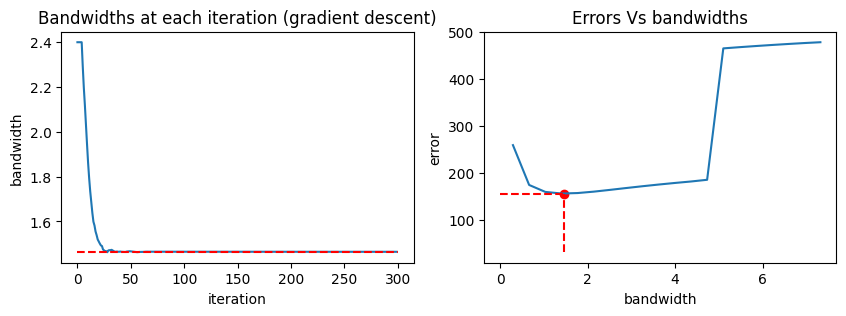

In [11]:
# Plot graphic of learning algorithm

gc1_fit.plot_learning_curve()

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred1 = gc1_fit.predict(X_test1)
print(mean_absolute_percentage_error(y_test1, y_pred1))
print(mean_squared_error(y_test1, y_pred1))

0.11280702906754467
81.88152269757128


Text(0, 0.5, 'prediction')

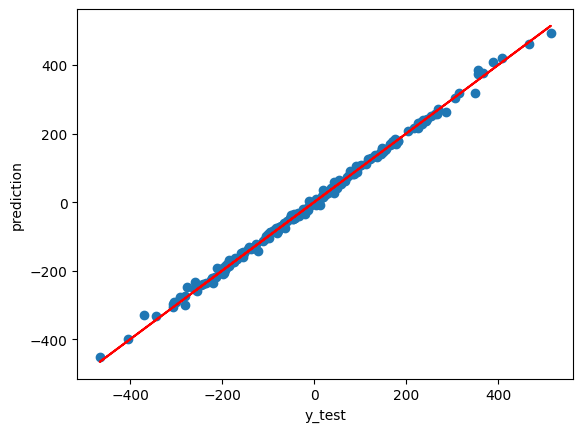

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_test1, y_pred1)
plt.plot(y_test1, y_test1, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

## We can improve this result by choosing other basic regressors. It is also possible to set parameters and hyperparameters of each individual estimator.

In [14]:
gc2 = GradientCOBRA(learning_rate=0.1,
                    speed="linear",
                    kernel='radial',
                    opt_method='grad',
                    loss_function="weighted_mse",
                    opt_params={
                                'max_iter' : 300
                    },
                    estimator_list=['random_forest', 'adaboost', 'knn', 'svm', 'lasso', 'ridge'],
                    estimator_params={
                        'random_forest' : {
                            'n_estimators' : 300,
                            'min_samples_leaf' : 10},
                        'adaboost' : {
                            'n_estimators' : 300,
                            'max_depth' : 10},
                        'knn' : {
                            'n_neighbors' : 30},
                            'svm' : {'C' : 7}
                    })

gc2_fit = gc2.fit(X_train1, y_train1)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 2.500 	~ gradient: 0.052 	~ threshold: 1e-05
		~    Stopped at: 300 	~ bandwidth: 1.229 	~ gradient: -0.000 	~ stopping criterion: 0.000                                                                                 


In [15]:
print("Optimal bandwidth: {}".format(gc2_fit.optimization_outputs['opt_bandwidth']))

Optimal bandwidth: 1.2293092468836424


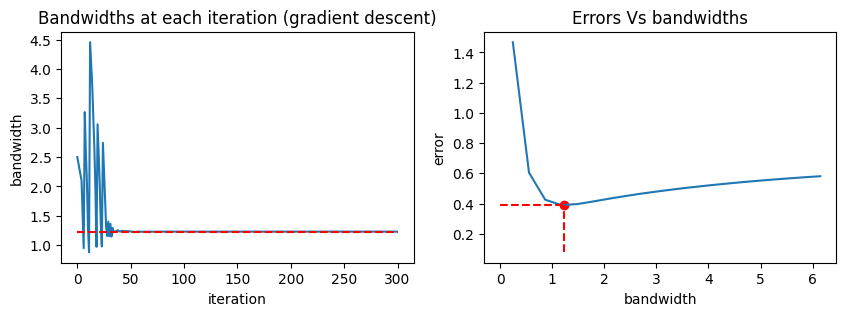

In [16]:
# Plot graphic of learning algorithm

gc2_fit.plot_learning_curve()

In [17]:
y_pred2 = gc2_fit.predict(X_test1)
print(mean_absolute_percentage_error(y_test1, y_pred2))
print(mean_squared_error(y_test1, y_pred2))

0.11350672076884342
79.05192599856808


Text(0, 0.5, 'prediction')

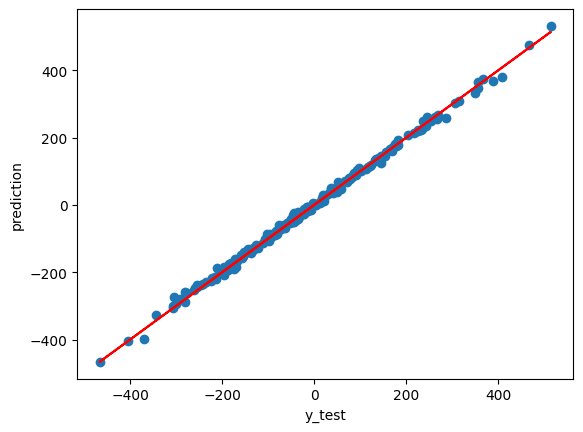

In [18]:
plt.clf()

plt.scatter(y_test1, y_pred2)
plt.plot(y_test1, y_test1, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

# Real Dataset

In [19]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X_real, y_real = data['data'], data['target']

In [20]:
# For 1000 observations
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real[:1000,:], y_real[:1000], test_size=0.2)
print('shape: x_train = {} , x_train = {} , y_train = {} , y_test = {}'.format(X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape))

shape: x_train = (800, 8) , x_train = (200, 8) , y_train = (800,) , y_test = (200,)


In [21]:
gc_real = GradientCOBRA(opt_method="grad",
                        estimator_list=['random_forest', 'knn', 'ridge', 'lasso'],
                        estimator_params={
                                'random_forest' : {'n_estimators': 100},
                                'knn' : {'n_neighbors' : 10}
                        })
gc_real_fit = gc_real.fit(X_train_real, y_train_real)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 2.500 	~ gradient: 0.000 	~ threshold: 1e-05
		~    Stopped at: 10 	~ bandwidth: 2.264 	~ gradient: -0.000 	~ stopping criterion: 0.000                                                                                  


In [22]:
print("Optimal bandwidth: {}".format(gc_real_fit.optimization_outputs['opt_bandwidth']))

Optimal bandwidth: 2.264470923800676


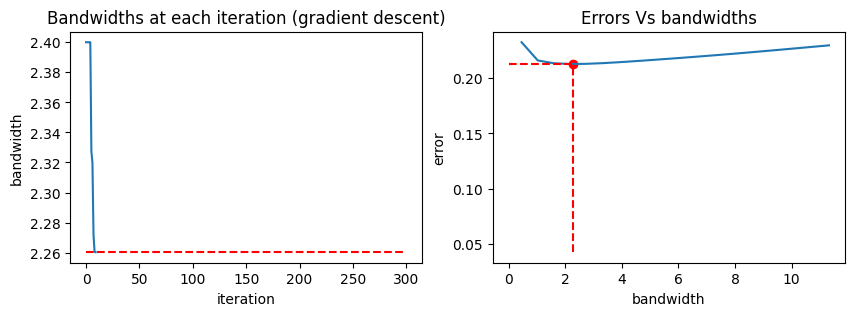

In [23]:
gc_real_fit.plot_learning_curve()

In [24]:
y_pred_real = gc_real_fit.predict(X_test_real)
print(mean_absolute_percentage_error(y_test_real, y_pred_real))
print(mean_squared_error(y_test_real, y_pred_real))

0.16036027263497452
0.17554322473044284


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


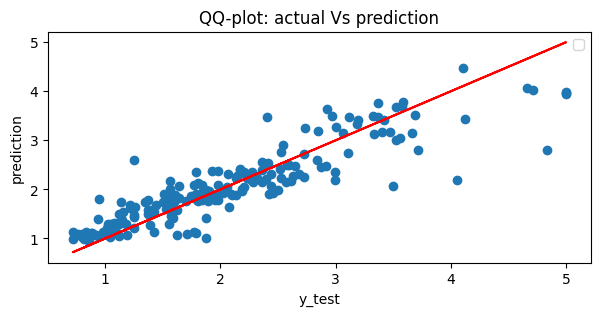

In [25]:
gc_real_fit.plot_learning_curve(y_test=y_test_real, fig_type='qq')

## Compare to Adaboost

In [26]:
ada = AdaBoostRegressor(n_estimators=1000)
ada.fit(X_train_real, y_train_real)

AdaBoostRegressor(n_estimators=1000)

In [27]:
ada_pred = ada.predict(X_test_real)
print(mean_absolute_percentage_error(y_test_real, ada_pred))
print(mean_squared_error(y_test_real, ada_pred))

0.29536700235962887
0.3045951769819739


Text(0, 0.5, 'prediction')

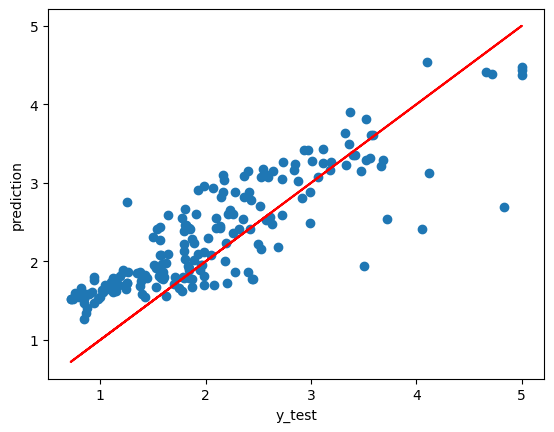

In [28]:
plt.clf()

plt.scatter(y_test_real, ada_pred)
plt.plot(y_test_real, y_test_real, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

# Pretrained estimators

In [83]:
# X_k and X_l split
id_k = np.random.permutation(range(len(y_train_real)))
k =int(.5 * len(y_train_real))
X_k, X_l, y_k, y_l = X_train_real[id_k[:k],:], X_train_real[id_k[k:],:], y_train_real[id_k[:k]], y_train_real[id_k[k:]]

# Building basic estiators
rf_real = RandomForestRegressor(n_estimators=300).fit(X_k, y_k)
lm_real = LinearRegression().fit(X_k, y_k)
knn_real = KNeighborsRegressor(n_neighbors=10).fit(X_k, y_k)
tr_real = DecisionTreeRegressor(min_samples_leaf=5).fit(X_k, y_k)

# External estiator
import xgboost 
xgb = xgboost.XGBRegressor(n_estimators = 500)
xgb_real = xgb.fit(X_k, y_k)

# All pretrained estimators
basic_estimators = (rf_real, lm_real, knn_real, tr_real, xgb_real)

# Predicted features on X_l for aggregation
pred_feature_l = np.column_stack([est.predict(X_l) for est in basic_estimators])

# Predicted features on Testing data
pred_feature_test = np.column_stack([est.predict(X_test_real) for est in basic_estimators])

In [84]:
gc3_fit = GradientCOBRA().fit(X=pred_feature_l,
                              y=y_l,
                              as_predictions=True)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 2.500 	~ gradient: 0.004 	~ threshold: 1e-05
		~    Stopped at: 33 	~ bandwidth: 1.386 	~ gradient: -0.000 	~ stopping criterion: 0.000                                                                                  


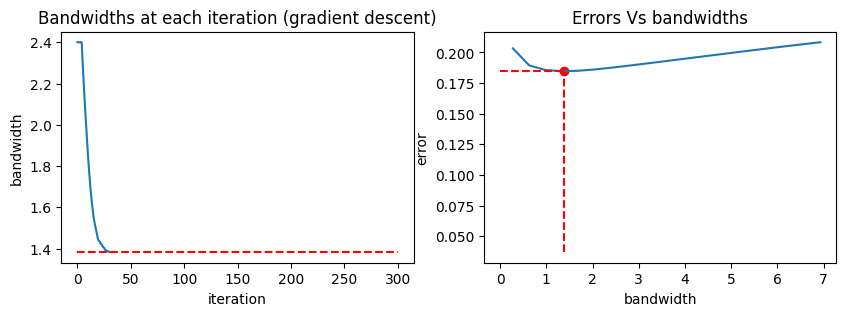

In [85]:
gc3_fit.plot_learning_curve()

In [86]:
pred_add = gc3_fit.predict(pred_feature_test)
print(mean_absolute_percentage_error(y_test_real, pred_add))
print(mean_squared_error(y_test_real, pred_add))

0.15790692263517156
0.1944507429738392


Text(0, 0.5, 'prediction')

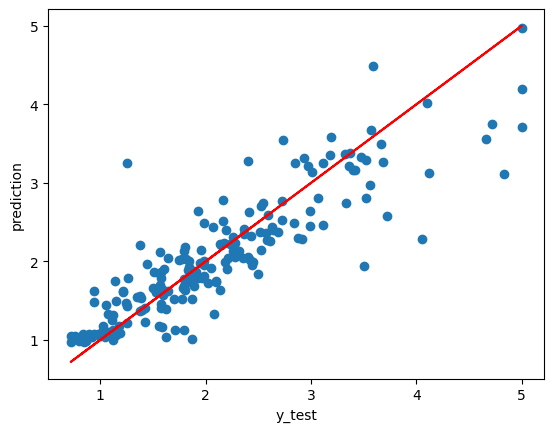

In [87]:
plt.clf()

plt.scatter(y_test_real, pred_add)
plt.plot(y_test_real, y_test_real, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

In [88]:
[mean_squared_error(pred_feature_test[:,i], y_test_real) for i in range(5)]

[0.16558712870135783,
 0.3005801360328284,
 0.93464521010461,
 0.24123499871604356,
 0.19282413543795976]